<a href="https://colab.research.google.com/github/rashidmeras/EVA-M6/blob/master/Assignment12/EVA_S12_Assignment12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA Session12 Assignment 12: 

Objective:

To train the network incorporating OneCycleLR technique.




# # 1. Import APIs and library

In [1]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Model, Sequential, load_model
from keras.layers.convolutional import MaxPooling2D, SeparableConv2D, Convolution2D, Conv2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dropout, Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.layers.advanced_activations import ReLU
import tensorflow as tf

import cv2
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

import matplotlib.gridspec as gridspec

import os
import warnings

from keras.callbacks import Callback

Using TensorFlow backend.


# # 2. Define helper functions:


1.   get_cifar10_data
2.   get_cifar10_labels
3.   show_examples
4.   plot_model_history
5.   get_cutout_eraser

In [0]:
def get_cifar10_data():
    from keras.datasets import cifar10
    (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
    num_train, img_channels, img_rows, img_cols =  train_features.shape
    num_test, _, _, _ =  test_features.shape
    num_classes = len(np.unique(train_labels))

    # Flatten 32x32x3 images to a 1024*3 vector for each image.
    train_features = train_features.reshape(train_features.shape[0], 32, 32, 3)
    test_features = test_features.reshape(test_features.shape[0], 32, 32, 3)

    train_features = train_features.astype('float32')/255
    test_features = test_features.astype('float32')/255

    # convert class labels to binary class labels
    train_labels = np_utils.to_categorical(train_labels, num_classes)
    test_labels = np_utils.to_categorical(test_labels, num_classes)
    return (train_features, train_labels), (test_features, test_labels)

def get_cifar10_labels():
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    return class_names

def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()
        
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()    
        
# Cut-out
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
  
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img

    return eraser

# #3. Implement OneCycleLR class

In [0]:
class OneCycleLR(Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
      
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

# # 4. Normalization

170500096/170498071 [==============================] - 9s 0us/step


W0724 13:12:49.210167 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.227086 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.242470 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.255375 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.268691 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.283370 140229811455872 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 13:12:49.295276 140229

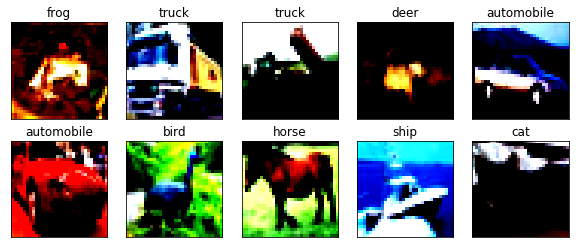

In [4]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

#  load cifar10 data  
(train_features, train_labels), (test_features, test_labels) = get_cifar10_data()

# # create generator that centers pixel values
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# # prepare an iterators to scale images
# train_iterator = datagen.flow(train_features, train_labels, batch_size, shuffle=False)

# # calculate mean on training dataset
# xyz = datagen.fit(train_features)

# train_features, train_labels = train_iterator.next()

# train_features = min_max_scale(train_features)


train_features_mean = np.mean(train_features, axis=(0,1,2))
train_features_std  = np.std(train_features, axis=(0,1,2))

train_features = (train_features - train_features_mean) / train_features_std
test_features  = (test_features - train_features_mean) / train_features_std

show_examples(train_features[0:10], train_labels[0:10], classes=get_cifar10_labels())

# # 5. Implement the function to create the model

In [0]:
# Define the model
def build_model(summary=False, lrate=0.0):
    
    input = Input(shape=(32, 32, 3,))
        
    x = Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)) (input)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same') (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Dropout(0.2) (x)

    x = Convolution2D(32, 1, 1) (x)


    x = Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same') (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same') (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Dropout(0.3) (x)

    x = Convolution2D(32, 1, 1) (x)

    x = Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same') (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same') (x)
    x = Activation('relu') (x)
    x = BatchNormalization() (x)

    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Dropout(0.5) (x)

    x = Convolution2D(10, 1, 1) (x)

    x = AveragePooling2D(pool_size = (4,4)) (x)
    x = Flatten() (x)

    output = Activation('softmax') (x)
    
    model = Model(inputs=[input], outputs=[output])
    
    sgd = SGD(lr=lrate, momentum=0.9, decay=0.0, nesterov=False)
  
    model.compile(optimizer= sgd,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])    
    
    #Print model summary
    if (summary == True):
        model.summary()
        i=0
        for layer in model.layers[0:]:
            if "conv" in layer.name:
                print ("Layer No.:", i, " Name:", layer.name)
                i+=1        
    
    return model

# # 6. Implement the function to train the network

In [0]:
def train_network(model, epochs=25, verbose=2, with_cutout=False, lrate=None):
  
    save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    cutout_fn = get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)  

    # Train the model
    start = time.time() 
                                                                                                   
    datagen = ImageDataGenerator(featurewise_center=False,             # set input mean to 0 over the dataset
                                 samplewise_center=False,              # set each sample mean to 0
                                 featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                 samplewise_std_normalization=False,   # divide each input by its std
                                 zca_whitening=False,                  # apply ZCA whitening
                                 rotation_range=0,                     # randomly rotate images in the range (degrees, 0 to 180)
                                 width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
                                 height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
                                 horizontal_flip=True,                 # randomly flip images
                                 vertical_flip=False,                  # randomly flip images                                      
                                 preprocessing_function=cutout_fn if with_cutout else None)
    

    train_iterator      = datagen.flow(train_features, train_labels, batch_size=batch_size, shuffle=True)
    validation_iterator = datagen.flow(test_features, test_labels, batch_size=batch_size, shuffle=True)
                                  
    xyz = datagen.fit(train_features)
    
    
    ################OneCycleLR###################################
    
    max_lr = 0.0005
    base_lr = max_lr/10
    max_m = 0.98
    base_m = 0.85

    cyclical_momentum = True
    augment = True
    cycles = 2.35
    
    iterations = round(len(train_iterator)/batch_size*epochs)
    iterations = list(range(0,iterations+1))
    step_size = len(iterations)/(cycles)  
  
    one_cyc_lr = OneCycleLR(base_lr=lrate,
                            max_lr=max_lr,
                            step_size=step_size,
                            max_m=max_m,
                            base_m=base_m,
                            cyclical_momentum=cyclical_momentum) 
    
    #############################################################
        
    train_history = model.fit_generator(train_iterator,
                                        steps_per_epoch  = len(train_iterator), 
                                        validation_data  = validation_iterator, 
                                        validation_steps = len(validation_iterator),
                                        epochs           = epochs, 
                                        verbose          = verbose,
                                        callbacks        = [save_mcp, one_cyc_lr])
  
    end = time.time()
    print ("Model took %0.2f seconds to train \n"%(end - start))

    # plot model history
    plot_model_history(train_history)
        
    # Plot Learning Rate
    plt.plot(one_cyc_lr.history['iterations'], one_cyc_lr.history['lr'])
    plt.xlabel('Training Iterations')
    plt.ylabel('Learning Rate')
    plt.title("One Cycle Policy")
    plt.show()

    # Plot momentum
    plt.plot(one_cyc_lr.history['iterations'], one_cyc_lr.history['momentum'])
    plt.xlabel('Training Iterations')
    plt.ylabel('Momentum')
    plt.title("One Cycle Policy")
    plt.show()    

    # Plot losses
    val_loss = train_history.history['val_loss']
    loss = train_history.history['loss']
    plt.plot(range(len(val_loss)),val_loss,'c',label='Validation loss')
    plt.plot(range(len(loss)),loss,'m',label='Train loss')

    plt.title('Training and validation losses')
    plt.legend()
    plt.xlabel('epochs')
    plt.show()    
    
    return train_history  

# # 7. Build the model

In [7]:
# model = build_model(summary=True)
model = build_model(lrate=0.07)

W0724 13:12:50.016175 140229811455872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 13:12:50.047426 140229811455872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  """
W0724 13:12:50.055241 140229811455872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 13:12:50.097704 140229811455872 deprecation_wrapper

# # 8. Train the network with the new learning rate for just 10 epochs

Epoch 1/50
 - 31s - loss: 0.3147 - acc: 0.8998 - val_loss: 0.2864 - val_acc: 0.9049

Epoch 00001: val_acc improved from -inf to 0.90494, saving model to best_new_model.h5
Epoch 2/50
 - 28s - loss: 0.2684 - acc: 0.9105 - val_loss: 0.2624 - val_acc: 0.9127

Epoch 00002: val_acc improved from 0.90494 to 0.91267, saving model to best_new_model.h5
Epoch 3/50
 - 29s - loss: 0.2455 - acc: 0.9184 - val_loss: 0.2340 - val_acc: 0.9216

Epoch 00003: val_acc improved from 0.91267 to 0.92163, saving model to best_new_model.h5
Epoch 4/50
 - 27s - loss: 0.2294 - acc: 0.9232 - val_loss: 0.2219 - val_acc: 0.9256

Epoch 00004: val_acc improved from 0.92163 to 0.92563, saving model to best_new_model.h5
Epoch 5/50
 - 27s - loss: 0.2182 - acc: 0.9271 - val_loss: 0.2107 - val_acc: 0.9296

Epoch 00005: val_acc improved from 0.92563 to 0.92959, saving model to best_new_model.h5
Epoch 6/50
 - 27s - loss: 0.2077 - acc: 0.9308 - val_loss: 0.2006 - val_acc: 0.9334

Epoch 00006: val_acc improved from 0.92959 to 0.

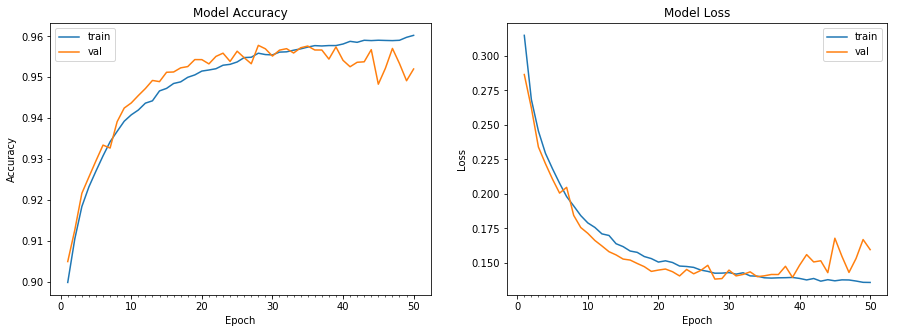

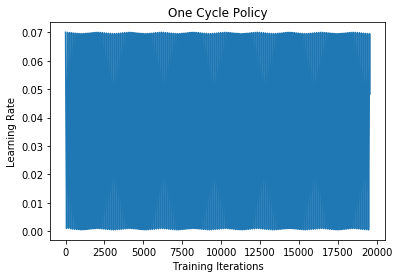

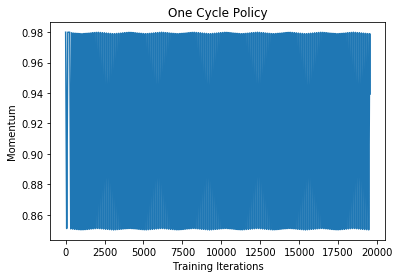

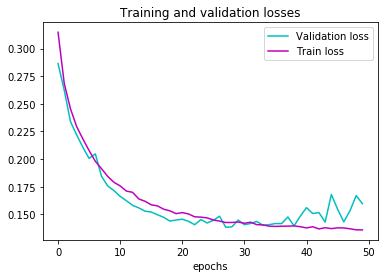

In [8]:
train_history = train_network(model, epochs=50, verbose=2, with_cutout=True, lrate=0.07)

# Summary:

The network was trained inorporating OneCycleLR class and a validation accuracy of 95.7 was achieved.

Reference: OneCycleLR: https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras

Thank you!




